In [1]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_WL_miscentering as mis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_WL_DATAOPS_make_profile as prf
import CL_Mass_richness_relation as mass_richness
import CL_WL_fit_cluster_mass as fit

sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/DESC_note/Notebooks/')
import analysis_Mass_observable_relation as analysis

import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

In [2]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

# Fiducial Mass richness relation

In [3]:
from statistics import median

## match redmapper to cosmodc2

In [4]:
dat_RM = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Galaxy_Cluster_Catalogs_details/cosmoDC2/RedMapper_galaxy_clusters.pkl')
dat_cosmodc2 = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Galaxy_Cluster_Catalogs_details/cosmoDC2/SkySim5000_DM_halos.pkl')

In [5]:
dat_cosmodc2['M200c'] = dat_cosmodc2['baseDC2/sod_halo_mass']/0.71    

In [6]:
low_M_cut = 1e13*np.linspace(1, 10, 10)

In [7]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin

In [8]:
Binned_data = []
Matched_data = []
for low_M_cut_value in low_M_cut:
    dat_cosmodc2_cut = dat_cosmodc2[(dat_cosmodc2['M200c'] > low_M_cut_value)]
    match_1 = match.match_nearest_neghbor(base_catalog = dat_RM, target_catalog =dat_cosmodc2_cut, label_base = '_RedMapper', label_target = '_cosmoDC2')
    match_1_selection = match.selection_cut(match = match_1, label_base = '_RedMapper', label_target = '_cosmoDC2')
    match_1_selection_repetition = match.find_repetition(match = match_1_selection, label_base = '_RedMapper', label_target = '_cosmoDC2', id_base = 'cluster_id', id_target = 'halo_id', )
    binned_data = match.make_binned(match = match_1_selection_repetition, Z_bin = Z_bin, Richness_bin = Obs_bin)
    Matched_data.append(match_1_selection_repetition)    
    Binned_data.append(binned_data)

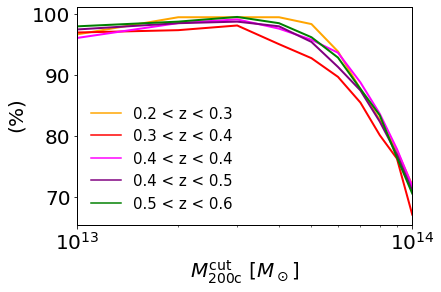

In [9]:
plt.rcParams['axes.linewidth'] = 1
color_z = ['orange','red','magenta','purple','green','cyan','blue','black']
for i, z_bin in enumerate(Z_bin):
    dat = []
    plt.plot([],[], label = f'{z_bin[0]:.1f} < z < {z_bin[1]:.1f}',  color = color_z[i])
    mask_base = (dat_RM['redshift'] > z_bin[0])*(dat_RM['redshift'] < z_bin[1])
    n_base = len(dat_RM[mask_base])
    for d, matched_data in enumerate(Matched_data):
        mask = (matched_data['redshift_RedMapper'] > z_bin[0])*(matched_data['redshift_RedMapper'] < z_bin[1])
        dat.append(len(matched_data[mask]))
    plt.plot(low_M_cut, 100*np.array(dat)/n_base, '-', color = color_z[i], linewidth = 2)
plt.xlim(1e13, 1e14)
plt.xscale('log')
plt.legend(loc='lower left', frameon = False, fontsize = 15, numpoints = 1, ncol = 1)
plt.tick_params(axis='both', which = 'major', labelsize= 20)
plt.xlabel(r'$M_{\rm 200c}^{\rm cut}\ [M_\odot]$', fontsize = 20)
plt.ylabel(r'$(\%)$', fontsize = 20)
plt.show()
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/low_mass_cut_recovery_rate.png', bbox_inches='tight', dpi=300)

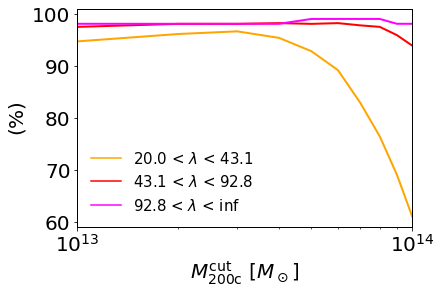

In [11]:
plt.rcParams['axes.linewidth'] = 1
color_z = ['orange','red','magenta','purple','green','cyan','blue','black']
for i, l_bin in enumerate(Obs_bin):
    dat = []
    plt.plot([],[], label = f'{l_bin[0]:.1f} < $\lambda$ < {l_bin[1]:.1f}',  color = color_z[i])
    mask_base = (dat_RM['richness'] > l_bin[0])*(dat_RM['richness'] < l_bin[1])
    n_base = len(dat_RM[mask_base])
    for d, matched_data in enumerate(Matched_data):
        mask = (matched_data['richness_RedMapper'] > l_bin[0])*(matched_data['richness_RedMapper'] < l_bin[1])
        dat.append(len(matched_data[mask]))
    plt.plot(low_M_cut, 100*np.array(dat)/n_base, '-', color = color_z[i], linewidth = 2)
plt.xlim(1e13, 1e14)
plt.xscale('log')
plt.legend(loc='lower left', frameon = False, fontsize = 15, numpoints = 1, ncol = 1)
plt.tick_params(axis='both', which = 'major', labelsize= 20)
plt.xlabel(r'$M_{\rm 200c}^{\rm cut}\ [M_\odot]$', fontsize = 20)
plt.ylabel(r'$(\%)$', fontsize = 20)
plt.show()

## fiducial constraints

In [12]:
def lnL_validation(theta, binned_m200c, binned_m200c_err, logrichness_individual, z_individual):
    return mass_richness.lnL_validation_binned(theta, binned_m200c, binned_m200c_err, logrichness_individual, z_individual, analysis.z0, analysis.richness0)

In [13]:
npath = 100
nwalkers = 100
initial_binned = [14.15,0,0.75]
pos_binned = initial_binned + 0.01 * np.random.randn(npath, len(initial_binned))
nwalkers, ndim = pos_binned.shape

In [14]:
sampler = {low_M_cut[i]: 0 for i in range(len(low_M_cut))}
for i,binned_data in enumerate(Binned_data):
    m200c_mean_val = np.array(binned_data['m200'])
    m200c_err_mean_val = np.array(binned_data['m200_err'])
    logrichness_mean_val = np.array(binned_data['logrichness'])
    z_mean_val = np.array(binned_data['z_mean'])
    logrichness_individual_val = binned_data['logrichness_in_bin']
    z_individual_val = binned_data['redshift_in_bin']
    sampler_binned_true = emcee.EnsembleSampler(nwalkers, ndim, lnL_validation, args = (m200c_mean_val, m200c_err_mean_val, logrichness_individual_val, z_individual_val))
    sampler_binned_true.run_mcmc(pos_binned, nwalkers, progress=True)
    flat_samples_binned_true = sampler_binned_true.get_chain(discard=0, flat=True)
    sampler[low_M_cut[i]] = flat_samples_binned_true

100%|██████████| 100/100 [00:09<00:00, 10.33it/s]


In [15]:
labels = [r'$\log_{10}(M_{0})$', r'$G_z$',r'$F_\lambda$']
label_plot = [f'{low_M_cut[i]:.1e}' for i in range(len(low_M_cut))]
sampler_tot = [ sampler[low_M_cut[i]] for i in range(len(low_M_cut))]
k = sampler[low_M_cut[0]]
a = len(k)
middle = np.mean(k[5000:a-1], axis = 0)
std = np.std(k[5000:a-1], axis = 0)
range_corner_plot = [(middle[i]- 3*std[i], middle[i]+ 3*std[i]) for i in range(3)]

In [16]:
range_corner_plot

[(14.141043942597097, 14.188232142993972),
 (-0.6300302454762916, 0.6036560158702688),
 (0.6729779526934758, 0.8521922889081652)]

(0.9058823529411765, 0.963834422657952, 0.8875816993464052, 1.0)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


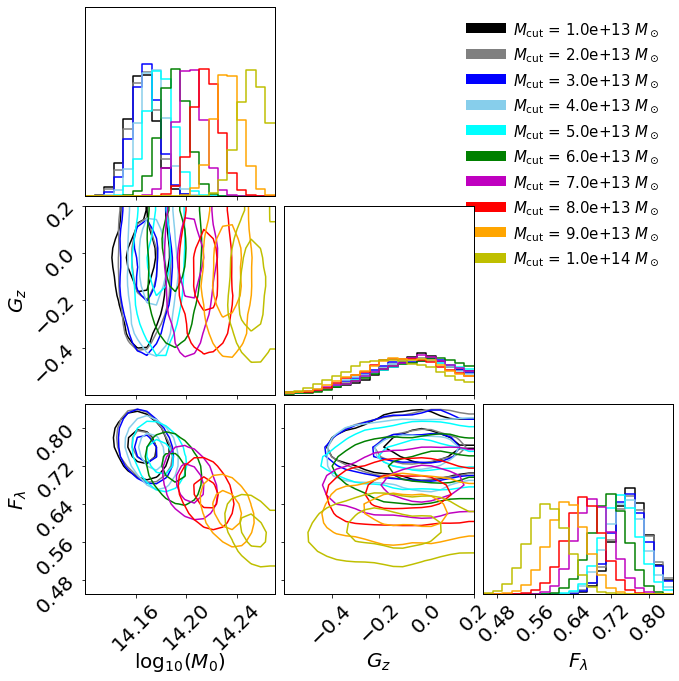

In [17]:
import matplotlib.pylab as pl
colors = plt.cm.get_cmap('Greens', len(sampler_tot))
print(colors(1))
plt.rcParams['axes.linewidth'] = 1.
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
truth = [14.162, -0.23, 0.8]
bins = 20
c = ['k','grey', 'b', 'skyblue', 'cyan', 'g', 'm', 'r', 'orange', 'y']
fig, axs = plt.subplots(len(labels), len(labels), figsize = (10,10))
plt.subplots_adjust(wspace=0, hspace=0)
for i, name in enumerate(label_plot):
    axs[0,2].plot([],[], c[i], linewidth = 10, label = r'$M_{\rm cut}$ = ' + label_plot[i] + r' $M_\odot$')

for i,sample in enumerate(sampler_tot):
    a = len(sample)
    k = sampler[low_M_cut[0]]
    a = len(k)
    middle = np.mean(k[5000:a-1], axis = 0)
    std = np.std(k[5000:a-1], axis = 0)
    range_corner_plot = [(middle[i]- 10*std[i], middle[i]+ 10*std[i]) for i in range(3)]
    sample_cut = sample[5000:a-1]
    fig = corner.corner(sample_cut,bins=bins, levels=(sigma1, sigma2),
    fig = fig,color = c[i],smooth1d=True,smooth=True,plot_datapoints=False,
    fill_contours=False, labels = labels,label_kwargs={"fontsize": 20},
    use_math_text=True,show_title = True,plot_density=False,
    range = [(14.12, 14.27), (-0.6, 0.2), (0.45, 0.85)],max_n_ticks = 5);
    
for i in range(len(labels)):
    for j in range(len(labels)):
        axs[i,j].tick_params(axis='both', which = 'major', labelsize= 20)
        axs[i,j].legend(frameon = False, fontsize = 15, loc = 'upper right')
        if i == j:
            axs[i,j].set_ylim(0,2000)
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/low_M_cut_effect.png', bbox_inches='tight', dpi=300)

In [18]:
plt.rcParams['axes.linewidth'] = 1

In [19]:
index = 3
sampler_select = sampler[low_M_cut[0]][5000:len(sampler[low_M_cut[0]])-1]
logM0_bf, alpha_bf, beta_bf = np.mean(sampler_select, axis = 0)
data_matched = Matched_data[index]
binned_data = Binned_data[index]
lnlambda = np.linspace(-1, 6,100)

NameError: name 'z0' is not defined

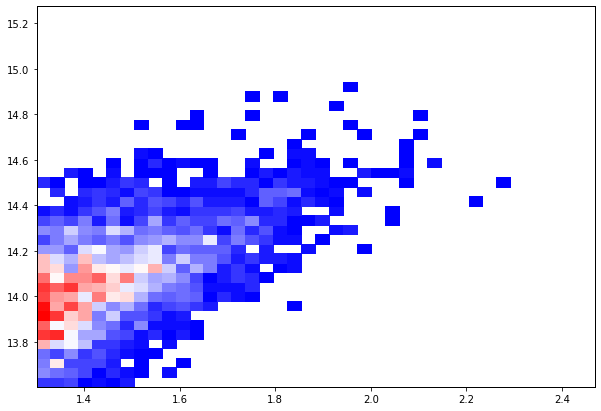

In [20]:
plt.figure(figsize = (10,7))
plt.hist2d(np.log10(data_matched['richness_RedMapper']), np.log10(data_matched['M200c_cosmoDC2']), bins = [40,40], 
           cmin = 2, cmap = 'bwr')
mu_list = np.zeros([len(sampler_select), len(lnlambda)])

for i in range(len(sampler_select)):
    logM0, alpha, beta = sampler_select[i]
    mu_list[i] = mass_richness.mu_logM_lambda_f(analysis.z0, lnlambda, logM0, alpha, beta, z0, richness0)
err_mu = np.std(mu_list, axis = 0)
plt.fill_between(lnlambda, np.mean(mu_list, axis = 0)-3*err_mu, np.mean(mu_list, axis = 0)+3*err_mu, label = f'best fit $z = {z0:.2f}$')
for k, z_bin in enumerate(Z_bin):
        #plt.plot([],[], '-', c = color_z[k],label = f'{z_bin[0]:.2f}'+ r'$< z < $'+ f'{z_bin[1]:.2f}',)
        mask = (binned_data['z_mean'] > z_bin[0])*(binned_data['z_mean'] < z_bin[1])
        f_cut = Table(binned_data)[mask]
        logrichness = f_cut['logrichness']
        logm200 = np.log10(f_cut['m200'])
        plt.errorbar(logrichness, logm200, marker = '.', elinewidth = 2, capsize = 0, markersize = 7, c = color_z[k], markerfacecolor = None)
        print(z0)
plt.xlim(1.3, 2.2)
plt.ylim(13.6, 15)
plt.legend(loc='best', frameon = True, framealpha = 1, fontsize = 15, numpoints = 1, ncol = 1)
plt.tick_params(axis='both', which = 'major', labelsize= 15)
plt.ylabel(r'cosmoDC2 $\log_{10}M_{\rm 200c}$', fontsize = 20)
plt.xlabel(r'redMaPPer $\log\ \lambda$', fontsize = 20)
plt.colorbar()
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/m_lambda_validation.png', bbox_inches='tight', dpi=300)

In [ ]:
binned_data.keys()

In [ ]:
#binned_data = Table(binned_data)
#for d in binned_data:
#    plt.figure()
#    z_mean, logrichness_mean, M200_mean = d['z_mean'], d['logrichness'], d['m200']
#    plt.hist(10**np.log10(d['M200c_in_bin']), bins = 20)
#    plt.vlines(10**mass_richness.mu_logM_lambda_f(z_mean, logrichness_mean, logM0_bf, alpha_bf, beta_bf, z0, richness0),0, 50)
#    plt.vlines(10**np.mean(np.log10(d['M200c_in_bin'])),0, 50, 'r')
#    plt.vlines(10**np.log10(np.mean(d['M200c_in_bin'])),0, 50, 'g')